In [1]:
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import cKDTree
import xarray as xr
import yaml

### Files paths

In [2]:
yaml_file = './config/pre_processing.yaml'
params = yaml.safe_load(open(yaml_file))

# The global mesh
INPUT_GRID = params['input_grid_nc']

# The SSH and seg masks info
INPUT_PATH_SSH_SEG_MASK = params['input_path_ssh_seg_masks']

# Output mesh details
OUTPUT_PATH_MESH = params['output_subset_pre_proc']
OUTPUT_MESH = params['output_mesh']

# The /raw destination folder for the pre-processed data
OUTPUT_SUBSET_PRE_PROCESSED = params['output_subset_pre_proc_raw']

### Reduce the mesh to a subset

In [3]:
files = os.listdir(OUTPUT_PATH_MESH)

if OUTPUT_MESH in files:
    data_mesh = xr.open_dataset(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')
else:
    data_mesh = xr.open_dataset(INPUT_GRID, engine='netcdf4')

    # Deletion of useless fields
    vars_keys = data_mesh.data_vars
    for key in vars_keys:
        if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
            data_mesh = data_mesh.drop_vars(key)

    data_mesh = data_mesh.drop_vars('nz')
    data_mesh = data_mesh.drop_vars('nz1')

    # RoI definition
    model_lon = data_mesh.lon.values
    model_lat = data_mesh.lat.values
    left = params['input_left']
    right = params['input_right']
    bottom = params['input_bottom']
    top = params['input_top']
    region_mask = (model_lon > left) & (model_lon < right) & (model_lat < top) & (model_lat > bottom)

    # Nodes extraction
    nodes_subset = []
    for i in range(len(region_mask)):
        if region_mask[i]:
            nodes_subset.append(i)

    nodes_subset = np.array(nodes_subset, dtype="int32")
    data_mesh['nodes'] =(('nodes_subset'), nodes_subset)

    # Prepare the translation from global to local nodes indexing
    tmp_index_dict = {}
    tmp_nodes = data_mesh.nodes.values

    for i in range(data_mesh.dims['nodes_subset']):
        tmp_index_dict[tmp_nodes[i]] = i

    # RoI: edges extraction
    edge_0 = data_mesh.edges[0].values
    edge_1 = data_mesh.edges[1].values
    edge_0 -= 1
    edge_1 -= 1

    edges_subset = []
    for i in range(len(edge_0)):
        if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
            edges_subset.append([edge_0[i], edge_1[i]])

    edges_subset_loc = copy.deepcopy(edges_subset)

    # Global to local translation
    for i in range(len(edges_subset)):
        edges_subset_loc[i][0] = tmp_index_dict[edges_subset[i][0]]
        edges_subset_loc[i][1] = tmp_index_dict[edges_subset[i][1]]

    edges_subset = np.array(edges_subset, dtype="int32")
    edges_subset_loc = np.array(edges_subset_loc, dtype="int32")
    data_mesh = data_mesh.drop_vars('edges')
    data_mesh['edges_global'] = (('n2', 'edges_subset'), edges_subset.T)
    data_mesh['edges_local'] = (('n2', 'edges_subset'), edges_subset_loc.T)

    data_mesh.to_netcdf(OUTPUT_PATH_MESH+OUTPUT_MESH, engine='netcdf4')

data_mesh

<xarray.Dataset>
Dimensions:       (nod2: 8852366, nodes_subset: 239536, n2: 2,
                   edges_subset: 716080)
Dimensions without coordinates: nod2, nodes_subset, n2, edges_subset
Data variables:
    lon           (nod2) float64 ...
    lat           (nod2) float64 ...
    nodes         (nodes_subset) int32 ...
    edges_global  (n2, edges_subset) int32 ...
    edges_local   (n2, edges_subset) int32 ...

### Interpolation of SSH and segmentation mask to the unstructured subset grid

#### First, some helper functions from https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/FESOM/STARTHERE_FESOM.ipynb

In [4]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [5]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    
    xs, ys, zs = lon_lat_to_cartesian(lons.flatten(), lats.flatten())
    xt, yt, zt = lon_lat_to_cartesian(model_lon, model_lat)

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

### The entire interpolation process

In [6]:
# SSH and segmentation masks (the SSH information is stored together with the segmentation masks)
data_files = []
for file in os.listdir(INPUT_PATH_SSH_SEG_MASK):
    data_files.append(file)

# Target coordinates(the unstructured FESOM mesh)
model_lon = data_mesh.lon[data_mesh.nodes].values
model_lat = data_mesh.lat[data_mesh.nodes].values

# Source coordinates(since lat and lon should always be the same, we just take them from a file and calculate the indexes once)
data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + '/' + str(data_files[0]))
data_lon, data_lat = np.meshgrid(data_month['LONGITUDE'], data_month['LATITUDE'])
data_lon = data_lon.T
data_lat = data_lat.T

# Perform a K-Nearest Neighbors between matrix and mesh points
distances, inds = create_indexes_and_distances(model_lon, model_lat, data_lon, data_lat, k=1, workers=-1)

for file in data_files:
    data_month = xr.open_dataset(INPUT_PATH_SSH_SEG_MASK + '/' + str(file))
    
    year = file.split('_')[3]
    month = file.split('_')[4].split('.')[0]
    day = None
    
    print(f'Preprocessing year {year}, month {month}')

    for d in range(data_month.dims['TIME']):
        day = d+1
        
        # SSH values
        data_ssh_values = data_month.ssh.values[d]
        
        # To avoid the e+36 values of SSH that NetCDF put there to create the land
        data_ssh_values[data_ssh_values > 10] = 0
        
        # Segmentation mask
        data_seg_mask_values = data_month.seg_mask.values[d]
        
        # TODO Temporary fix for single "3" value in the seg_mask variable
        for r in range(data_month.dims['LONGITUDE']):
            for c in range(data_month.dims['LATITUDE']):
                if data_seg_mask_values[r][c] < 0 or data_seg_mask_values[r][c] > 2:
                    neighbors = data_seg_mask_values[r][c-1]+data_seg_mask_values[r-1][c-1]+data_seg_mask_values[r-1][c]+data_seg_mask_values[r-1][c+1]+data_seg_mask_values[r][c+1]+data_seg_mask_values[r+1][c+1]+data_seg_mask_values[r+1][c]+data_seg_mask_values[r+1][c-1]
                    neighbors /= 8
                    print(file, d, r, c, data_seg_mask_values[r][c])
                    print(f'Neighborhood average(assuming the 8 neighbors exist): {neighbors}, assigning a {round(neighbors)}')
                    data_seg_mask_values[r][c] = round(neighbors)
        
        flat_ssh = data_ssh_values.flatten()
        flat_seg_mask = data_seg_mask_values.flatten()
        
        ssh = flat_ssh[inds]
        seg_mask = flat_seg_mask[inds]
        
        # Area of influence to take care of KNN indexes crossing land - TODO disabled now, see pre_processing_demo.ipynb
        radius_of_influence = 10000
        
        ssh[distances >= radius_of_influence] = np.nan
        ssh = np.ma.masked_invalid(ssh)
        
        seg_mask[distances >= radius_of_influence] = 0
        seg_mask = np.ma.masked_invalid(seg_mask)

        ssh = np.array(ssh, dtype="float64")
        seg_mask = np.array(seg_mask, dtype="float64")
        
        data_output = xr.Dataset(
            data_vars=dict(
                ssh=('nodes_subset', ssh),
                seg_mask=('nodes_subset', seg_mask),
            )
        )
        
        # Save the result in a separate file for each timestamp
        file_name = '/data_subset_' + str(year) + '_' + str(month) + '_' + str(day) + '.nc'
        data_output.to_netcdf(OUTPUT_SUBSET_PRE_PROCESSED + file_name, engine='netcdf4')

Preprocessing year 2009, month 4
Preprocessing year 2019, month 4
Preprocessing year 2014, month 8
Preprocessing year 2009, month 6
Preprocessing year 2010, month 1
seg_mask_gridded_2010_1.nc 11 256 19 3
Neighborhood average(assuming the 8 neighbors exist): 1.125, assigning a 1
Preprocessing year 2010, month 12
Preprocessing year 2016, month 12
Preprocessing year 2015, month 5
Preprocessing year 2019, month 1
Preprocessing year 2012, month 11
Preprocessing year 2016, month 2
Preprocessing year 2015, month 4
Preprocessing year 2011, month 3
Preprocessing year 2018, month 5
Preprocessing year 2009, month 9
Preprocessing year 2010, month 7
Preprocessing year 2015, month 10
Preprocessing year 2013, month 11
Preprocessing year 2014, month 11
Preprocessing year 2018, month 8
Preprocessing year 2016, month 8
Preprocessing year 2017, month 8
Preprocessing year 2017, month 7
Preprocessing year 2009, month 10
Preprocessing year 2010, month 2
Preprocessing year 2013, month 9
Preprocessing year 20

In [7]:
# Useful pieces of code 
'''
if len(ssh) == 0:
    ssh = this_ssh
else:
    ssh = np.vstack((ssh, this_ssh))

if len(seg_mask) == 0:
    seg_mask = this_seg_mask
else:
    seg_mask = np.vstack((seg_mask, this_seg_mask))

data_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)
data_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)
'''

"\nif len(ssh) == 0:\n    ssh = this_ssh\nelse:\n    ssh = np.vstack((ssh, this_ssh))\n\nif len(seg_mask) == 0:\n    seg_mask = this_seg_mask\nelse:\n    seg_mask = np.vstack((seg_mask, this_seg_mask))\n\ndata_mesh['ssh'] = (['graph_n', 'nodes_subset'], ssh)\ndata_mesh['seg_mask'] = (['graph_n', 'nodes_subset'], seg_mask)\n"

### Group of plots to understand where we started and where we got

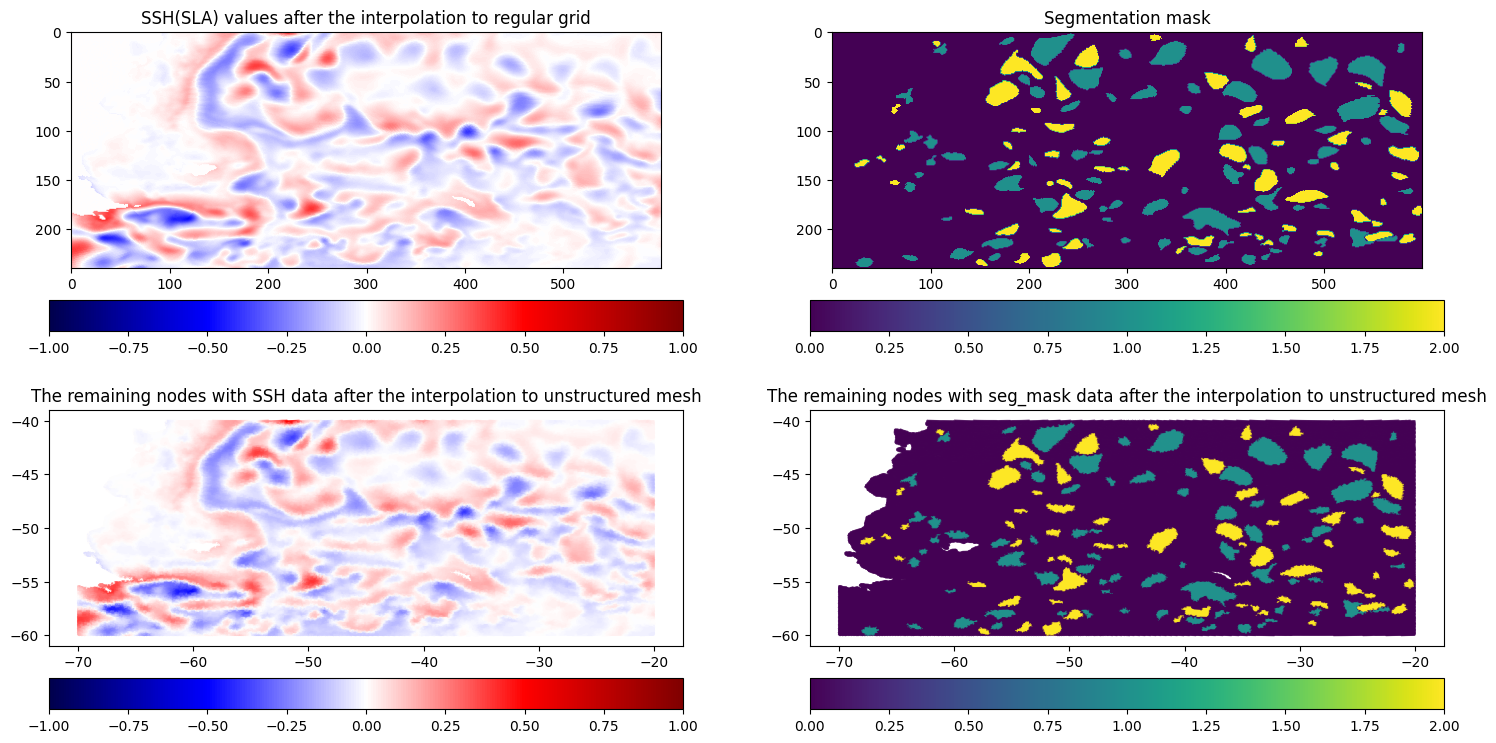

In [8]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values
uns_ssh = data_output.ssh.values
str_ssh = data_month.ssh.values[-1]
uns_seg_mask = data_output.seg_mask.values
str_seg_mask = data_month.seg_mask.values[-1]

fig, axes = plt.subplots(2, 2, figsize=(18, 9))

im = axes[0][0].imshow(np.flipud(str_ssh.T), cmap=cm.seismic, vmin=-1, vmax=1)
axes[0][0].set_title("SSH(SLA) values after the interpolation to regular grid")
cb = plt.colorbar(im, orientation='horizontal', pad=0.1, ax=axes[0][0])

im2 = axes[0][1].imshow(np.flipud(str_seg_mask.T), cmap=cm.viridis, vmin=0, vmax=2)
axes[0][1].set_title("Segmentation mask")
cb = plt.colorbar(im2, orientation='horizontal', pad=0.1, ax=axes[0][1])

im3 = axes[1][0].scatter(model_lon_roi, model_lat_roi, c=uns_ssh, s=0.1, cmap=cm.seismic, vmin=-1, vmax=1)
axes[1][0].set_title(f"The remaining nodes with SSH data after the interpolation to unstructured mesh")
plt.colorbar(im3, orientation='horizontal', pad=0.1, ax=axes[1][0])

im4 = axes[1][1].scatter(model_lon_roi, model_lat_roi, c=uns_seg_mask, s=0.1, cmap=cm.viridis, vmin=0, vmax=2)
axes[1][1].set_title(f"The remaining nodes with seg_mask data after the interpolation to unstructured mesh")
plt.colorbar(im4, orientation='horizontal', pad=0.1, ax=axes[1][1])

#plt.close()